# Quantum Variational Circuit
In this notebook we will implement a quantum variational circuit (QVC), we use it as a binary classificator for detecting entanglement in a quantum state.

In [2]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import IQPEmbedding, StronglyEntanglingLayers

import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

## Dataset

The dataset contains 10,000 examples consisting of 10 features and a binary label: _sep_. The feature are rappresente as observable generated from a determined quantum state


In [3]:
# Number of total exemples 
n_exemples = 2000

# Loading dataset with pandas
dataset = pd.read_csv('../datasets/ds_haar_obs.csv')
dataset = dataset[:n_exemples]
dataset

,P11,P22,P33,P44,P13,P14,P24,P12,P23,P34,sep
0,0.363562,0.363562,0.363562,0.363562,0.363562,0.363562,0.363562,0.363562,0.363562,0.363562,True
1,0.478920,0.478920,0.478920,0.478920,0.478920,0.478920,0.478920,0.478920,0.478920,0.478920,True
2,0.176573,0.067155,0.055469,0.062003,0.256511,0.179351,0.105687,0.311796,0.154631,0.023350,False
3,0.022839,0.022839,0.022839,0.022839,0.022839,0.022839,0.022839,0.022839,0.022839,0.022839,True
4,0.139089,0.347255,0.249997,0.201476,0.491367,0.382842,0.488343,0.233877,0.272572,0.224575,False
...,...,...,...,...,...,...,...,...,...,...,...
1995,0.157113,0.157113,0.157113,0.157113,0.157113,0.157113,0.157113,0.157113,0.157113,0.157113,True
1996,0.493741,0.493741,0.493741,0.493741,0.493741,0.493741,0.493741,0.493741,0.493741,0.493741,True
1997,0.092023,0.116030,0.074852,0.499082,0.156299,0.036411,0.091028,0.236941,0.058071,0.027507,False
1998,0.399581,0.211034,0.473830,0.197118,0.441907,0.306886,0.349018,0.268414,0.419103,0.464543,False


In [4]:
# Number of features
n_features = 5

# Dividing dataset in features and label
X = dataset.to_numpy()[:,0:n_features]
y = dataset.to_numpy()[:,-1]

# Scaling the inputs 
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Redifining labels on -1,1
y_scaled = np.array(2 * (y - 0.5),dtype=int)

In [5]:
# Spliting dataset in training and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled,train_size=0.8)
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 1600
Test size: 400


In [6]:
# Setting the number of qbits the same as the number of features
n_qubits = len(X_train[0])
print("Number of Qbits: ",n_qubits)

Number of Qbits:  5


## Quantum Circuit

In [7]:
dev_var = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev_var, diff_method="parameter-shift")
def quantum_model(x, params):
    """A variational quantum model."""

    # embedding
    IQPEmbedding(x, wires=range(n_qubits),n_repeats=2)

    # trainable measurement
    StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

## Functions

In [8]:
def quantum_model_plus_bias(x, params, bias):
    """Adding a bias."""
    return quantum_model(x, params) + bias

def hinge_loss(predictions, targets):
    """Implements the hinge loss."""
    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets
    # trick: since the max(0,x) function is not  differentiable,
    # use the mathematically equivalent relu instead
    hinge_loss = relu(hinge_loss)
    return hinge_loss

def quantum_model_train(n_layers, steps, batch_size):
    """Train the quantum model defined above."""

    params = np.random.random((n_layers, n_qubits, 3))
    params_torch = torch.tensor(params, requires_grad=True)
    bias_torch = torch.tensor(0.0)

    opt = torch.optim.Adam([params_torch, bias_torch], lr=0.1)

    loss_history = []
    for i in range(steps):

        batch_ids = np.random.choice(len(X_train), batch_size)

        X_batch = X_train[batch_ids]
        y_batch = y_train[batch_ids]

        X_batch_torch = torch.tensor(X_batch, requires_grad=False)
        y_batch_torch = torch.tensor(y_batch, requires_grad=False)

        def closure():
            opt.zero_grad()
            preds = torch.stack(
                [quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch]
            )
            loss = torch.mean(hinge_loss(preds, y_batch_torch))

            # bookkeeping
            current_loss = loss.detach().numpy().item()
            loss_history.append(current_loss)
            if i % 10 == 0:
                print("step", i, ", loss", current_loss)

            loss.backward()
            return loss

        opt.step(closure)

    return params_torch, bias_torch, loss_history


def quantum_model_predict(X_pred, trained_params, trained_bias, probs=False):
    """Predict using the quantum model defined above."""

    p = []
    for x in X_pred:

        x_torch = torch.tensor(x)
        pred_torch = quantum_model_plus_bias(x_torch, trained_params, trained_bias)
        pred = pred_torch.detach().numpy().item()
        if probs!=True:
            if pred > 0:
                pred = 1
            else:
                pred = -1

        p.append(pred)
    return p

## Training and test

In [9]:
n_layers = 2
batch_size = 20
steps = 100
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(X_test, trained_params, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, y_test))

step 0 , loss 1.0181504991160397
step 10 , loss 0.9772254117218271
step 20 , loss 0.7607896330264954
step 30 , loss 0.9512097499252793
step 40 , loss 0.8105478432670272
step 50 , loss 0.705216472445182
step 60 , loss 0.8716392558884495
step 70 , loss 0.8601614873608951
step 80 , loss 0.7308253933662616
step 90 , loss 0.8388577212521685
accuracy on test set: 0.5625


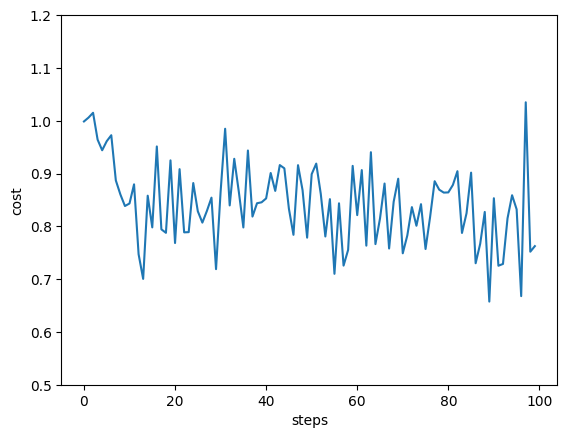

In [46]:
plt.plot(loss_history)
plt.ylim((0.5, 1.2))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

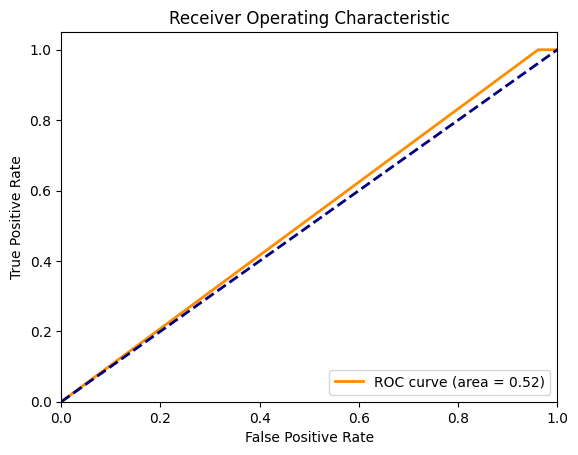

In [47]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for the trained model
pred = quantum_model_predict(X_test, trained_params, trained_bias, probs=True)
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


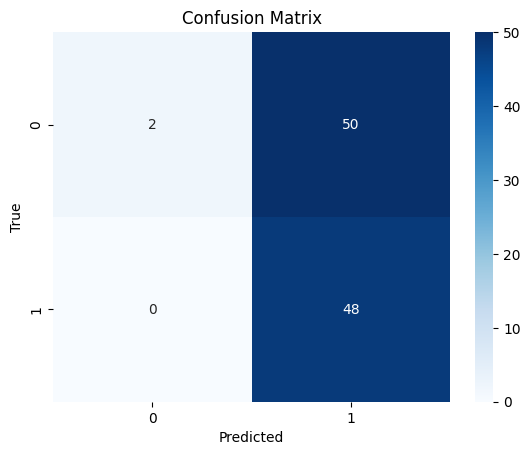

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test, pred_test)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()